****
# Jupyter Notebook 1
## This is the overall process for this kannada dateset recognization using resnet 50 based on pytorch cuda
#### tips:
1. I define all my class in the kannada.py to make the ipynb looks concise
****
author: Dennis Guo

1. clean the storage

In [1]:
%reset -f
import gc
gc.collect()
#clean the output

0

2. import basic packages and define the path

In [2]:
import kannada_dennis
from kannada_dennis import *
from init_imports import *

In [3]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath,"data")
modelPath = os.path.join(rootPath,"model")
if not os.path.exists(dataPath):
    os.makedirs(dataPath)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

3. download the data and unzip

In [4]:
!kaggle competitions download -c Kannada-MNIST -p ./data -q

In [5]:
zip_path = 'data/Kannada-MNIST.zip'
extract_to_dir = 'data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# List files to confirm
os.listdir(extract_to_dir)

['Dig-MNIST.csv',
 'Kannada-MNIST.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

4. train test split

In [6]:
seed(42)
train = pd.read_csv(os.path.join(dataPath,"train.csv"))
test = pd.read_csv(os.path.join(dataPath,"test.csv"))

6. transfer the data into DataLoader

In [28]:
train_temp = kannada_data(train, test_size=0.2, datatype="train")
val_temp = kannada_data(train, test_size=0.2, datatype="val")
test_temp = kannada_data()
train_dl = DataLoader(train_temp, batch_size=32)
val_dl = DataLoader(val_temp, batch_size=32)
test_dl = DataLoader(test, batch_size=32)

7. create the res50 model but only for conv1 layer and fc layer

In [8]:
# I want to create beautiful resnet class
num_classes = len(train.label.unique())
# Initialize the model
model50 = KannaResNet50(num_classes=num_classes).to(device=device)

2048


Define the function for loss and accuracy

8. run the train dataloder and use the val dataloader to test

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model50.parameters(), lr=0.001)
num_epochs = 10
train_accuracies = []
train_losses = []
val_accuracies = []
for epoch in trange(num_epochs, desc="out of epochs", leave=True):
    train_epoch_accuracy_list = []
    train_epoch_batch_loss = []
    val_epoch_accuracy_list = []
    for index, batch in enumerate(tqdm(iter(train_dl))):
        x, y = batch
        y = y.squeeze(1) 
        batch_loss = kannada_dennis.train_batch(x, y, model50, criterion, optimizer)
        train_epoch_batch_loss.append(batch_loss)
    
        
    for index, batch in enumerate(tqdm(iter(train_dl))):
        x, y = batch
        y = y.squeeze(-1)
        temp = kannada_dennis.accuracy(x, y, model50)
        train_epoch_accuracy_list.extend(temp)
    
    for index, batch in enumerate(tqdm(iter(val_dl))):
        x, y = batch
        y = y.squeeze(-1)
        temp = kannada_dennis.accuracy(x, y, model50)
        val_epoch_accuracy_list.extend(temp)
        
    train_accuracies.append(np.mean(train_epoch_accuracy_list))
    train_losses.append(np.mean(train_epoch_batch_loss))
    val_accuracies.append(np.mean(val_epoch_accuracy_list))
    
    
# tqdm here .... change the mini dataset to all 
# how did he know our 0 is 0?

out of epochs: 100%|██████████| 10/10 [09:00<00:00, 54.08s/it]


#### Conclusion
Original Resnet50 looks super strong, No free ride for me now, I need to create my own resnet network now

Then I want to try ResNet101 and ResNet152

Get some idea from the fastai, it's a new ResNet model in my following ipynb.

In [13]:
val_accuracies

[0.7544166666666666,
 0.8891666666666667,
 0.9074166666666666,
 0.93675,
 0.9504166666666667,
 0.9544166666666667,
 0.9465,
 0.9644166666666667,
 0.9640833333333333,
 0.9630833333333333]

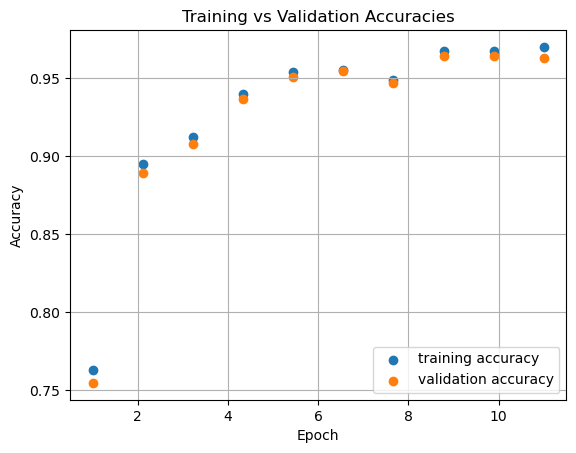

In [27]:
%matplotlib inline
x = np.linspace(1, 11, 10)
plt.scatter(x, train_accuracies, label = "training accuracy")
plt.scatter(x, val_accuracies, label = "validation accuracy")
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracies')
plt.grid()
plt.show()

Save my model50

In [31]:
torch.save(model50, "res50.pth")
torch.save(model50.state_dict(), "res50param.pth")

visualization with torchviz

In [14]:
model50.eval()
for i in model50.parameters():
    i.requires_grad = True
dummy_input = torch.randn(8, 1, 28, 28).to(device=device)
y = model50(dummy_input)
# for i,j in model.named_parameters():
#     print(i)
graph = make_dot(y, params=dict(model50.named_parameters()))
graph.render('ResNet50', format='png')

'ResNet50.png'

### prediction

In [35]:
len(test_dl)

157

In [42]:
type(test.iloc[1])

pandas.core.series.Series

In [49]:
test.head(1)

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
class testdata(Dataset):
    def __init__(self, data : pd.DataFrame) -> None:
        super().__init__()
        self.dataframe = data
    
        self.train = np.array(self.dataframe.drop(["id"], axis = 1))
        self.id = np.array(self.dataframe.id)
        
    def __len__(self):
        return len(self.train)
    
    def __getitem__(self, index):
        return torch.Tensor(self.train[index].reshape(-1,28,28)/255).to(device=device)

In [62]:
test_ds = testdata(test)
test_dl = DataLoader(test_ds, batch_size=32, shuffle= False)

In [50]:
test_dl = DataLoader(test, batch_size=32, shuffle= False)

In [70]:
model50.eval()
pred_list = []
with torch.no_grad():
    for index, batch in enumerate(tqdm(test_dl)):
        prediction = model50(batch)
        _, index = prediction.max(-1)
        temp = index.detach().cpu().tolist()
        pred_list.extend(temp)

100%|██████████| 157/157 [00:01<00:00, 91.73it/s] 


generating the submission.csv

In [73]:
submission = pd.DataFrame({
    "id" : test.id,
    "label" : np.array(pred_list)
})
submission.to_csv("res50.csv", sep=",")